# 📌BILSTM 실습

## 1. 기본 설정

In [1]:
import numpy as np
import pandas as pd
import math
import os
import re
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

from konlpy.tag import Mecab
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.keras.backend.set_floatx('float64')

In [2]:
data = pd.read_table('steam.txt', sep='\t', encoding='UTF-8', names=['label', 'reviews'])

In [3]:
data

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
...,...,...
99995,0,한글화해주면 10개산다
99996,0,개쌉노잼 ㅋㅋ
99997,0,노잼이네요... 30분하고 지웠어요...
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   label    100000 non-null  int64 
 1   reviews  100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [5]:
# 중복제거
data.drop_duplicates(subset=['reviews'], inplace=True)

In [6]:
data

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
...,...,...
99995,0,한글화해주면 10개산다
99996,0,개쌉노잼 ㅋㅋ
99997,0,노잼이네요... 30분하고 지웠어요...
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.


In [7]:
# 결측치 확인
data.isnull().sum()

label      0
reviews    0
dtype: int64

<AxesSubplot:>

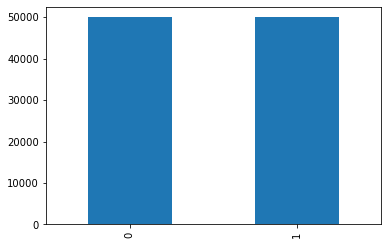

In [8]:
# data 분포 확인
data['label'].value_counts().plot(kind = 'bar')

## 2. 데이터 전처리

- 자연어 처리의 input은 '문자' 
- 딥러닝 모델의 input은 '숫자'
- 문자를 숫자로 바꿔주기

In [9]:
# data 한글과 공백을 제외하고 모두 제거
data['reviews'] = data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data['reviews'].replace('', np.nan, inplace=True)
print(data.isnull().sum())

label      0
reviews    0
dtype: int64


- 토큰화 작업(Tokenization): 문장을 의미있는 부분으로 나누는 과정
- 토큰(Token): 쪼개진 부분(단어)

- 불용어(stopword): 자주 등장하지만 분석을 하는 것에 있어서는 큰 도움이 되지 않는 단어
- 불용어 작업: 갖고 있는 데이터에서 유의미한 단어 토큰만을 선별하기 위해서는 큰 의미가 없는 단어 토큰을 제거하는 작업

- https://www.ranks.nl/stopwords/korean

In [10]:
# 불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [11]:
# 토큰화 작업하기
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic") 

data['tokenized'] = data['reviews'].apply(mecab.morphs)
data['tokenized'] = data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [12]:
# 부정 리뷰/긍정리뷰 단어 확인
negative_words = np.hstack(data[data.label == 0]['tokenized'].values)
positive_words = np.hstack(data[data.label == 1]['tokenized'].values)

In [13]:
negative_words

array(['노래', '너무', '적', ..., '분하', '지웠', '어요'], dtype='<U32')

In [14]:
positive_words

array(['막노동', '체험', '판', ..., '진짜', '손맛', '으로'], dtype='<U32')

In [15]:
# 부정리뷰 단어 빈도수 확인 -> 부정 단어 20개 추출
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 10900), ('없', 9527), ('있', 7732), ('는데', 7701), ('같', 5624), ('로', 5455), ('할', 5243), ('거', 5202), ('나', 5064), ('해', 4896), ('너무', 4682), ('으로', 4499), ('기', 4457), ('했', 4402), ('어', 4209), ('보', 4024), ('습니다', 3975), ('것', 3925), ('좋', 3890), ('겠', 3889)]


In [16]:
# 긍정리뷰 단어 빈도수 확인 -> 긍정 단어 20개 추출
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 13178), ('좋', 8593), ('습니다', 6896), ('재밌', 6613), ('할', 6488), ('지만', 6374), ('해', 5769), ('없', 5591), ('보', 5243), ('로', 5176), ('으로', 5132), ('수', 5127), ('는데', 5025), ('기', 4810), ('안', 4533), ('같', 4481), ('것', 4471), ('네요', 4218), ('어', 4132), ('나', 4093)]


In [17]:
# train/test 나누기
train_data, test_data = train_test_split(data, test_size = 0.25, random_state = 2021)

In [18]:
print(train_data.shape)
print(test_data.shape)

(74919, 3)
(24973, 3)


In [19]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(74919,)
(74919,)
(24973,)
(24973,)


In [21]:
# 정수 인코딩(단어 집합(Token Vocabulary) 생성, 단어에 고유 정수(번호) 부여)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

- fit_on_texts: 입력한 텍스트로부터 단어 빈도수가 높은 순으로 낮은 정수 인덱스를 부여됨

In [22]:
tokenizer.word_index

{'있': 1,
 '안': 2,
 '없': 3,
 '는데': 4,
 '좋': 5,
 '할': 6,
 '습니다': 7,
 '해': 8,
 '로': 9,
 '지만': 10,
 '같': 11,
 '으로': 12,
 '보': 13,
 '기': 14,
 '나': 15,
 '거': 16,
 '재밌': 17,
 '것': 18,
 '했': 19,
 '어': 20,
 '수': 21,
 '네요': 22,
 '너무': 23,
 '아': 24,
 '않': 25,
 '플레이': 26,
 '적': 27,
 '었': 28,
 '좀': 29,
 '겠': 30,
 '시간': 31,
 '에서': 32,
 '사': 33,
 '때': 34,
 '주': 35,
 '함': 36,
 '입니다': 37,
 '재미': 38,
 '사람': 39,
 '추천': 40,
 '개': 41,
 '아니': 42,
 '내': 43,
 '더': 44,
 '서': 45,
 '잘': 46,
 '스토리': 47,
 '재미있': 48,
 '그냥': 49,
 '라': 50,
 '생각': 51,
 '합니다': 52,
 '왜': 53,
 '말': 54,
 '못': 55,
 '았': 56,
 '시': 57,
 '보다': 58,
 '해서': 59,
 '많': 60,
 '잼': 61,
 '으면': 62,
 '한글': 63,
 '갓': 64,
 '진짜': 65,
 '어서': 66,
 '싶': 67,
 '분': 68,
 '정말': 69,
 '모르': 70,
 '그': 71,
 '이거': 72,
 '만들': 73,
 '그래픽': 74,
 '버그': 75,
 '돈': 76,
 '던': 77,
 '번': 78,
 '뭐': 79,
 '세요': 80,
 '정도': 81,
 '면서': 82,
 '감': 83,
 '화': 84,
 '니': 85,
 '까지': 86,
 '다가': 87,
 '중': 88,
 '원': 89,
 '야': 90,
 '어요': 91,
 '긴': 92,
 'ㅋㅋㅋ': 93,
 '라고': 94,
 '친구': 95,
 '성': 96,


In [23]:
# 빈도 수가 1인 단어들은 중요하지 않다고 판단해 제외
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 37125
등장 빈도가 1번 이하인 희귀 단어의 수: 15442
단어 집합에서 희귀 단어의 비율: 41.59461279461279
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.0230263746295818


In [24]:
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21685


- 0은 해당 단어가 존재하지 않음(패딩작업을 위해 존재)
- 1은 oov Token으로 사용
- 그래서 개수 셀 때 2개 더 더해주기

In [25]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

- OOV(Out-of Vocabulary): Token을 저장해둔 곳(Vocabulary)에 없어서 처음 본 Token이 나오는 현상
- Tokenizer = Tokenizer(num_words=숫자)와 같은 방법으로 빈도수가 높은 상위 몇 개의 단어만 사용하겠다고 지정 가능
- 위에서 vocab_size로 지정 => 전체 다쓴다는거쥥~
- texts_to_sequences: 입력으로 들어온 문장들에 대해서 각 단어를 이미 정해진 인덱스로 변환
- 기본적으로 단어 집합에 없는 단어인 OOV에 대해서는 단어를 정수로 바꾸는 과정에서 아예 단어를 제거한다는 특징
- 단어 집합에 없는 단어들은 OOV로 간주하여 보존하고 싶다면 Tokenizer의 인자 oov_token을 사용

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.122785942150855


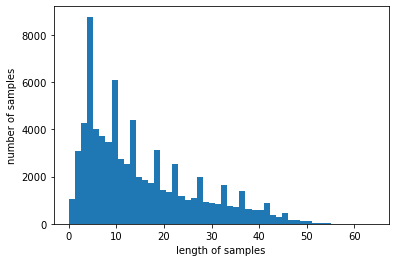

In [26]:
# 패딩 작업 전 데이터 길이 확인
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
# 길이 분포 확인
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [28]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99599567532935


In [29]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.79711421668736


In [30]:
# 데이터 길이 맞춰주는 패딩작업하기
X_train = pad_sequences(X_train, maxlen = 50)
X_test = pad_sequences(X_test, maxlen = 50)

## 3. BILSTM

In [31]:
tf.random.set_seed(0)

model = Sequential()
model.add(Embedding(vocab_size, 50))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [32]:
model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2, callbacks=[es, mc])

model.summary()

Epoch 1/30
469/469 [==============================] - ETA: 0s - loss: 0.5123 - acc: 0.7479
Epoch 00001: val_acc improved from -inf to 0.78550, saving model to best_model.h5
469/469 [==============================] - 112s 238ms/step - loss: 0.5123 - acc: 0.7479 - val_loss: 0.4647 - val_acc: 0.7855
Epoch 2/30
469/469 [==============================] - ETA: 0s - loss: 0.4363 - acc: 0.8011
Epoch 00002: val_acc improved from 0.78550 to 0.78597, saving model to best_model.h5
469/469 [==============================] - 112s 238ms/step - loss: 0.4363 - acc: 0.8011 - val_loss: 0.4577 - val_acc: 0.7860
Epoch 3/30
469/469 [==============================] - ETA: 0s - loss: 0.4119 - acc: 0.8139
Epoch 00003: val_acc did not improve from 0.78597
469/469 [==============================] - 125s 267ms/step - loss: 0.4119 - acc: 0.8139 - val_loss: 0.4658 - val_acc: 0.7834
Epoch 4/30
469/469 [==============================] - ETA: 0s - loss: 0.3947 - acc: 0.8251
Epoch 00004: val_acc did not improve from 0.

In [33]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 21s 27ms/step - loss: 0.4574 - acc: 0.7927
테스트 정확도: 0.7927


In [34]:
# 리뷰 넣으면 긍정/부정 분류해주는 함수 만들기
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = mecab.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [35]:
sentiment_predict("개노잼")

93.03% 확률로 부정 리뷰입니다.


In [36]:
sentiment_predict("오 생각보다 퀄리티가 좋고 빠르네요")

91.15% 확률로 긍정 리뷰입니다.


In [37]:
sentiment_predict("소리가 웅장하네요")

75.24% 확률로 긍정 리뷰입니다.


In [38]:
sentiment_predict("해본 게임 중에서 가장 소리가 웅장하네요")

94.10% 확률로 긍정 리뷰입니다.
